### Практическое задание


1. Сформируйте посредством sklearn.make_classification датасет из 1000 объектов с двумя признаками. Обучите случайный лес из 1, 3, 10 и 50 деревьев и визуализируйте их разделяющие гиперплоскости на графиках по подобию визуализации деревьев из предыдущего урока, заменив вызов функции predict на tree_vote. 

In [61]:
import matplotlib.pyplot as plt
import random
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [62]:
classification_data, classification_labels = make_classification(n_samples=1000,
                                                                 n_features=2, n_informative=2, 
                                                                 n_classes=2, n_redundant=0, 
                                                                 n_clusters_per_class=1, random_state=3)

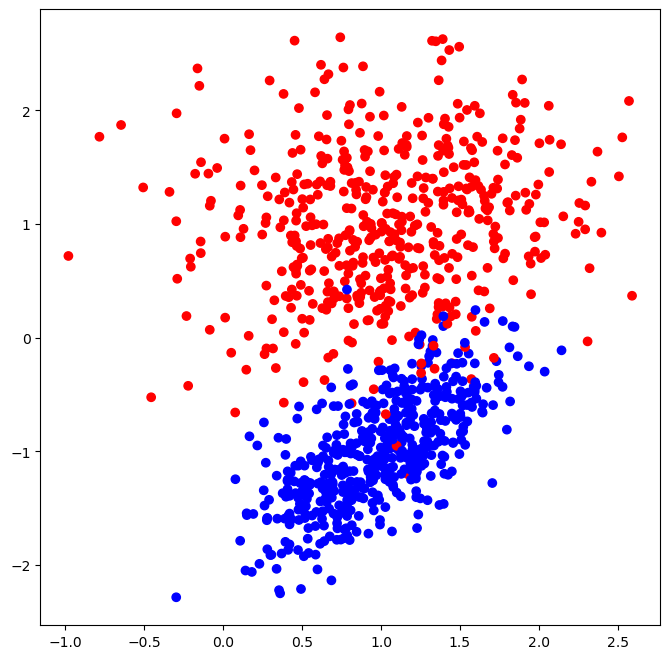

In [63]:
colors = ListedColormap(['red','blue'])
plt.figure(figsize=(8,8))
plt.scatter(classification_data[:,0],classification_data[:,1],c=classification_labels,cmap=colors)


In [64]:
# Реализуем класс узла

class Node:
       def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [65]:
# И класс терминального узла (листа)
class Leaf:
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
       
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
            
        # найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction    

In [66]:
import pandas as pd
d= pd.DataFrame(classification_labels)
d.groupby(0).count()

""
0
0
1


In [67]:
classification_data.shape[0]

1000

In [68]:
# Расчет критерия Джини
def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2      
    return impurity

In [69]:
# Расчет прироста
def gain(left_labels, right_labels, root_criterion, criterion):
    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])    
    return root_criterion - p * criterion(left_labels) - (1 - p) * criterion(right_labels)

In [70]:
# Разбиение датасета в узле

def split(data, labels, column_index, t):    
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)        
    true_data = data[left]
    false_data = data[right]    
    true_labels = labels[left]
    false_labels = labels[right]        
    return true_data, false_data, true_labels, false_labels

In [71]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):    
    #  обозначим минимальное количество объектов в узле
    min_leaf_samples = 5
    root_gini = gini(labels)
    best_gain = 0
    best_t = None
    best_index = None    
    n_features = data.shape[1]    
    feature_subsample_indices = get_subsample(n_features) # выбираем случайные признаки    
    for index in feature_subsample_indices:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf_samples or len(false_data) < min_leaf_samples:
                continue            
            current_gain = gain(true_labels, false_labels, root_gini, gini)            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index
    return best_gain, best_t, best_index

In [72]:
# Построение дерева с помощью рекурсивной функции
def build_tree(data, labels):
    gain, t, index = find_best_split(data, labels)
    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if gain == 0:
        return Leaf(data, labels)
    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)
    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [73]:
np.random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0] # размер совпадает с исходной выборкой
    bootstrap = []
    for i in range(N): 
        sample_index = np.random.randint(0, n_samples, size=n_samples)
        b_data = data[sample_index]
        b_labels = labels[sample_index]
        bootstrap.append((b_data, b_labels)) 
    return bootstrap

In [74]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = list(range(len_sample))
    len_subsample = int(np.sqrt(len_sample))
    subsample = np.random.choice(sample_indexes, size=len_subsample, replace=False)
    return subsample

In [75]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))    
    return forest

In [76]:
# Функция классификации отдельного объекта
def classify_object(obj, node):
    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer
    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [77]:
# функция формирования предсказания по выборке на одном дереве
def predict(data, tree):
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [78]:
# предсказание голосованием деревьев
def tree_vote(forest, data):
    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))     
    return voted_predictions

In [79]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [80]:
# Разобьем выборку на обучающую и тестовую
from sklearn.model_selection import train_test_split
train_data, test_data, train_labels, test_labels = train_test_split(classification_data, 
                                                                    classification_labels, 
                                                                    test_size=0.3,
                                                                    random_state=1)

In [81]:
# Визуализируем дерево на графике
def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

def visualize(train_data, train_labels, test_data, test_labels, my_forest):
    plt.figure(figsize = (16, 7))
    # график обучающей выборки
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(tree_vote(my_forest, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    
    train_accuracy = accuracy_metric(train_labels, tree_vote(my_forest, train_data))
    plt.title(f'Train accuracy={train_accuracy:.2f}')
    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)   
    test_accuracy = accuracy_metric(test_labels, tree_vote(my_forest, test_data))
    plt.title(f'Test accuracy={test_accuracy:.2f}')

In [82]:
%%time
n_trees = 1
my_forest_1 = random_forest(train_data, train_labels, n_trees)

CPU times: total: 922 ms
Wall time: 1.55 s


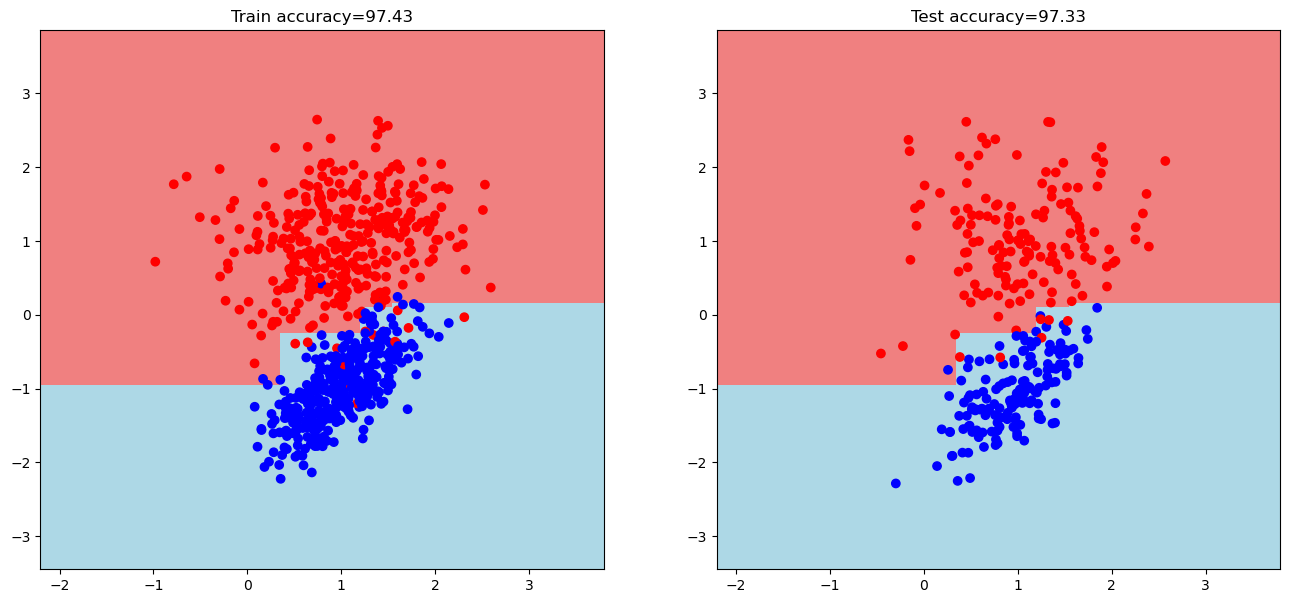

In [83]:
visualize(train_data, train_labels, test_data, test_labels, my_forest_1)

In [84]:
%%time
n_trees = 3
my_forest_1 = random_forest(train_data, train_labels, n_trees)

CPU times: total: 2.55 s
Wall time: 4.14 s


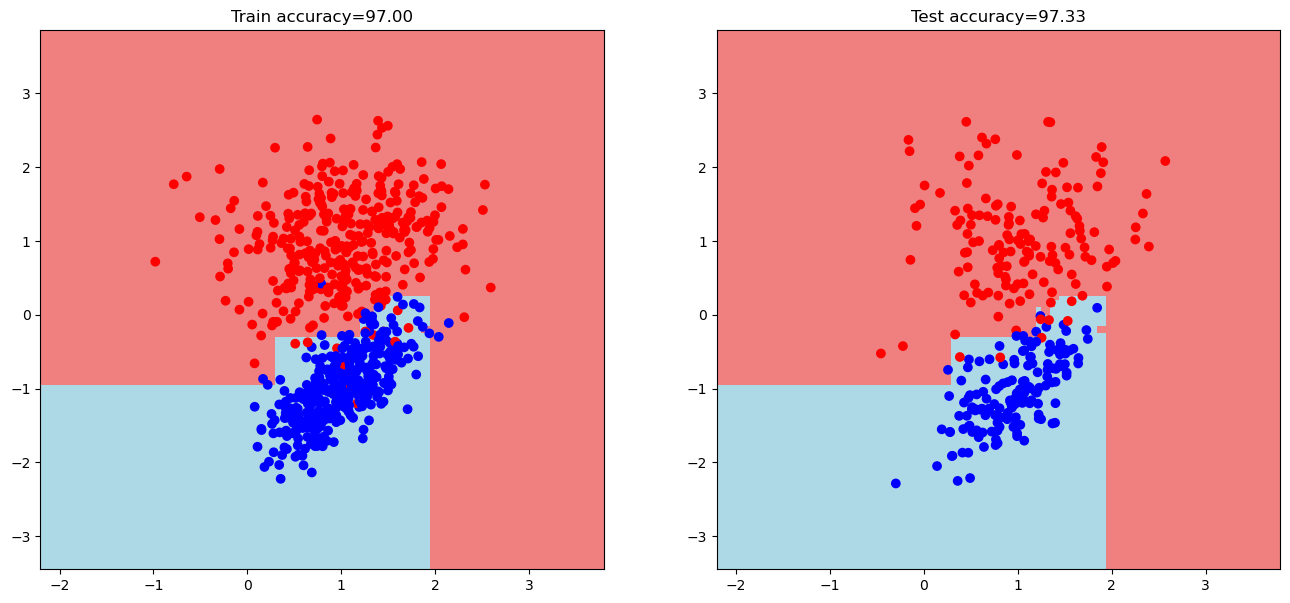

In [85]:
visualize(train_data, train_labels, test_data, test_labels, my_forest_1)

In [86]:
%%time
n_trees = 10
my_forest_1 = random_forest(train_data, train_labels, n_trees)

CPU times: total: 4.84 s
Wall time: 5.31 s


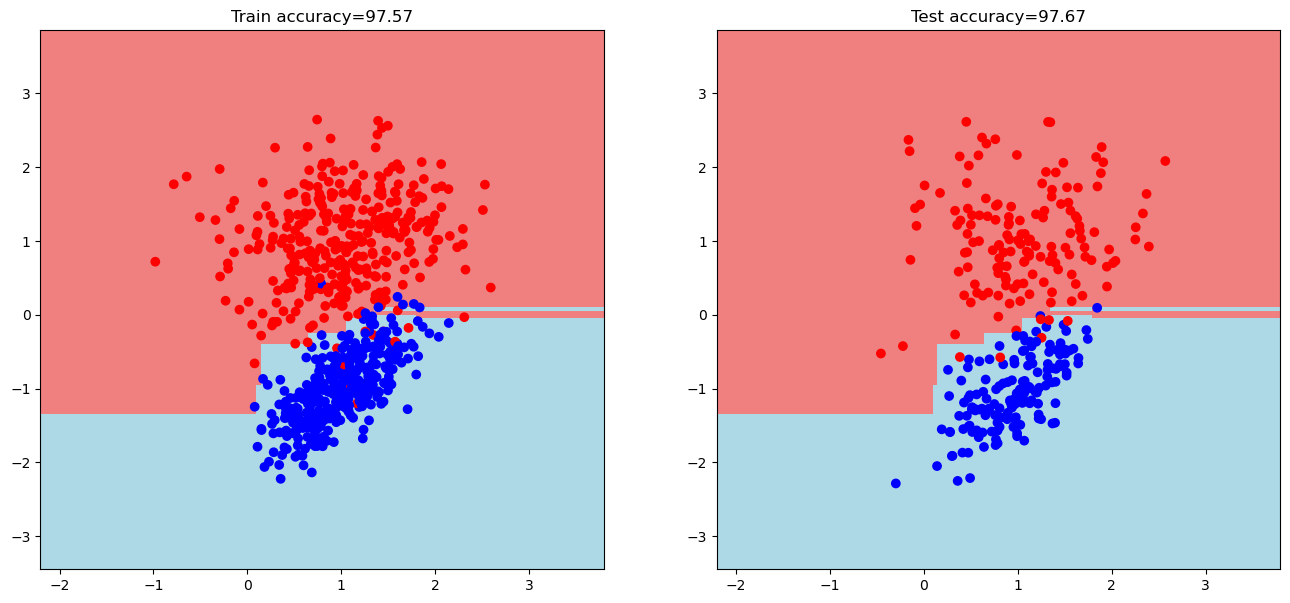

In [87]:
visualize(train_data, train_labels, test_data, test_labels, my_forest_1)

In [88]:
%%time
n_trees = 50
my_forest_1 = random_forest(train_data, train_labels, n_trees)

CPU times: total: 24.5 s
Wall time: 26.9 s


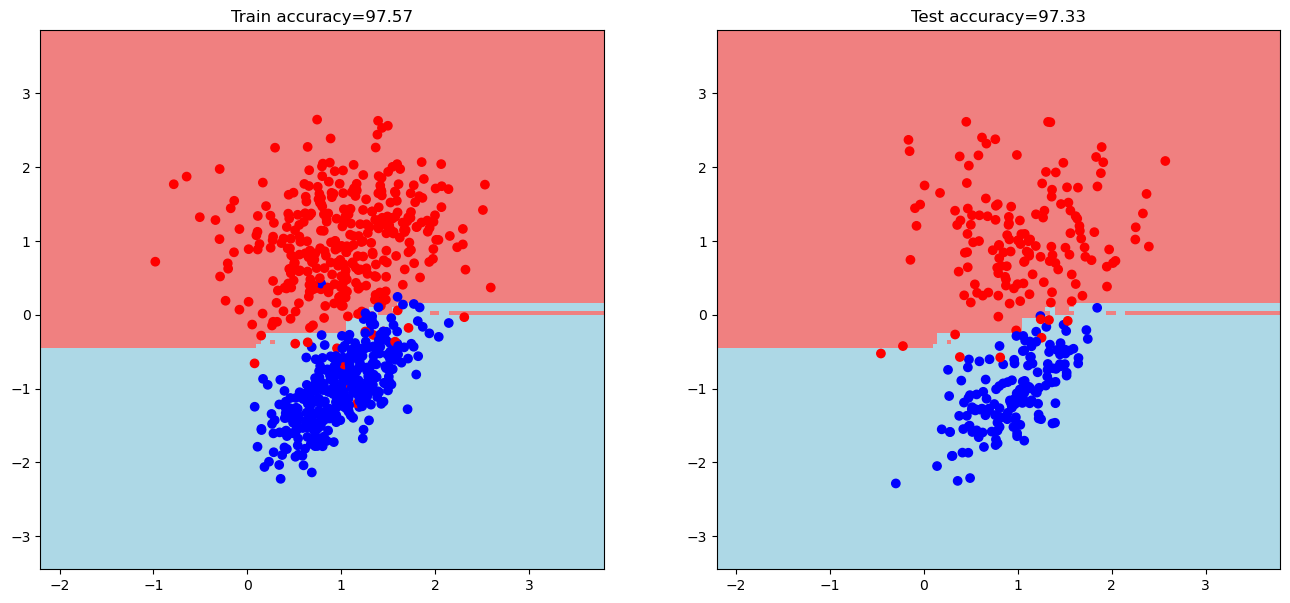

In [89]:
visualize(train_data, train_labels, test_data, test_labels, my_forest_1)

2. Сделайте выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нём.

Малое количество деревьев:

- Может привести к недообучению.
- Более простые модели с высокими ошибками.

Оптимальное количество деревьев:

- Минимизирует ошибку на тестовой выборке.
- Сохраняет баланс между сложностью модели и ресурсами.

Большое количество деревьев:

- Увеличивает устойчивость модели и снижает разброс предсказаний.
- Модель становится более точной, но затраты на обучение возрастают.

3. Замените в реализованном алгоритме проверку, используя отложенную выборку на Out-of-Bag.

In [90]:
# Функция для создания бутстрап-выборок и соответствующих OOB-выборок
def get_bootstrap_with_oob(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    oob_indices = []
    for _ in range(N):
        sample_indices = np.random.randint(0, n_samples, size=n_samples)
        oob_mask = np.ones(n_samples, dtype=bool)
        oob_mask[sample_indices] = False
        b_data = data[sample_indices]
        b_labels = labels[sample_indices]
        oob_data = data[oob_mask]
        oob_labels = labels[oob_mask]
        bootstrap.append((b_data, b_labels, oob_data, oob_labels))
    return bootstrap

In [91]:
# Создание случайного леса с использованием OOB оценки
def random_forest_with_oob(data, labels, n_trees):
    # Создаем бутстрап-выборки и соответствующие OOB-выборки
    bootstrap_samples, oob_indices_list = get_bootstrap_with_oob(data, labels, n_trees)
    # Список для хранения обученных деревьев
    trees = []
    # Матрица для хранения голосов OOB для каждого объекта
    # Строки - объекты, столбцы - количество классов
    oob_votes = np.zeros((data.shape[0], len(np.unique(labels))))
    # Проходим по каждой бутстрап-выборке, чтобы обучить деревья
    for i in range(n_trees):
        # Получаем данные и метки для текущей бутстрап-выборки
        b_data, b_labels = bootstrap_samples[i]
        # Получаем индексы объектов, которые попали в OOB-выборку
        oob_indices = oob_indices_list[i]
        # Строим дерево на бутстрап-выборке
        tree = build_tree(b_data, b_labels, calc_entropy)
        # Добавляем обученное дерево в список
        trees.append(tree)
        # Классифицируем объекты из OOB-выборки текущим деревом
        for index in oob_indices:
            obj = data[index]
            # Получаем предсказание для текущего объекта
            prediction = classify_object(obj, tree)
            # Увеличиваем счетчик голосов для соответствующего класса
            oob_votes[index, np.where(np.unique(labels) == prediction)[0][0]] += 1
    # Получаем окончательные предсказания для объектов, используя максимальное количество голосов
    oob_predictions = np.argmax(oob_votes, axis=1)
    # Рассчитываем точность OOB как долю правильных предсказаний
    oob_accuracy = np.sum(oob_predictions == labels) / len(labels)
    return trees, oob_accuracy


4. (На повторение) Перепишите функцию calc_gini из урока про решающие деревья так, чтобы в качестве критерия использовалась энтропия Шеннона. Переименуйте функцию в calc_entropy.

In [92]:
def calc_entropy(labels):
    # Подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    # Расчет энтропии Шеннона
    entropy = 0
    for label in classes:
        p = classes[label] / len(labels)
        entropy -= p * np.log2(p)    
    return entropy
